In [13]:
import requests  # API requests
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET  # Will be used to parse the data
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import pytz

In [14]:
# Link to connect to the API
api_link = "http://reports.sem-o.com/api/v1/documents/static-reports"

In [15]:
def apiQuery(parameters):
    Response = requests.get(api_link, params=parameters)
    return Response

In [16]:
#function to get all the dates between the range specified
def days_between_dates(dt1, dt2):
    date_format = "%Y-%m-%d"
    a = time.mktime(time.strptime(dt1, date_format))
    b = time.mktime(time.strptime(dt2, date_format))
    delta = b - a
    return int(delta / 86400)

In [17]:
# Specifying our parameters
startDate = '2024-05-10'
endDate = '2024-06-20'
PageSize = '1'
SortBy = 'PublishTime'
ForecastReportName = 'Forecast Availability'
OutturnReportName = 'Average Outturn Availability'
ResourceName = ''
ParticipantName = 'PT_400116'

# Getting the range of dates
dateRange = pd.date_range(start=startDate, end=endDate).date

NumberOfDays = days_between_dates(startDate, endDate)

In [18]:
# Function to filter XML strings from a JSON object
def filterXMLStrings(json_data):
    try:
        items = json_data.get('items', [])
        filtered_strings = [item['ResourceName'] for item in items if item['ResourceName'].endswith('.xml')]
        return filtered_strings
    except KeyError:
        print("KeyError: The JSON object does not contain the expected keys.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []


In [19]:
# Function to loop through dates and return all the XML file names we need
def RetrieveXMLFileNames(XMLFileType):
    XMLFileNames = []
    for date in dateRange:
        TypeParameters = {
            'ReportName': XMLFileType,
            'Date': date,
            'page_size': PageSize,
            'sort_by': SortBy,
        }
        Response = apiQuery(TypeParameters)
        if Response.status_code != 200:
            print(f"Failed to retrieve data: {Response.status_code}")
        else:
            GridInfo = Response.json()

            # Filtering data to isolate the names of the XML files we want to use
            FilteredGridInfo = filterXMLStrings(GridInfo)
            XMLFileNames.extend(FilteredGridInfo)  # Extend instead of append

            #print("\n\n\n" + XMLFileType + ":", FilteredGridInfo)

    return XMLFileNames


In [20]:
ForecastResponseData = RetrieveXMLFileNames(ForecastReportName)
OutturnResponseData = RetrieveXMLFileNames(OutturnReportName)

#Funtion to pass in the names we gathered and doing a api query to get the XML files content into a dataframe
def ResponseDataToDataFrame(ResponseData, Availability, ParticipantName):
    availability_array = []
    data_array = []
    for data in ResponseData:
        url = 'https://reports.sem-o.com/documents/' + data
        df = pd.read_xml(url)
        
        if 'ParticipantName' in df.columns and Availability in df.columns:
            filtered_df = df[df['ParticipantName'] == ParticipantName]
            availability_array.extend(filtered_df[Availability].dropna().tolist())
            data_array.extend(filtered_df['StartTime'].dropna().tolist())

    data = {'Times': data_array, 'Availability': availability_array}
    df = pd.DataFrame(data=data)
    return df

ForecastResponseData = RetrieveXMLFileNames(ForecastReportName)
OutturnResponseData = RetrieveXMLFileNames(OutturnReportName)
ParticipantName = 'PT_400116' 


/var/folders/7c/whdrky714c3g12864gvms8800000gn/T/ipykernel_95460/378924673.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_range = pd.date_range(start=min(Forecast['Times'].min(), Outturn['Times'].min()),


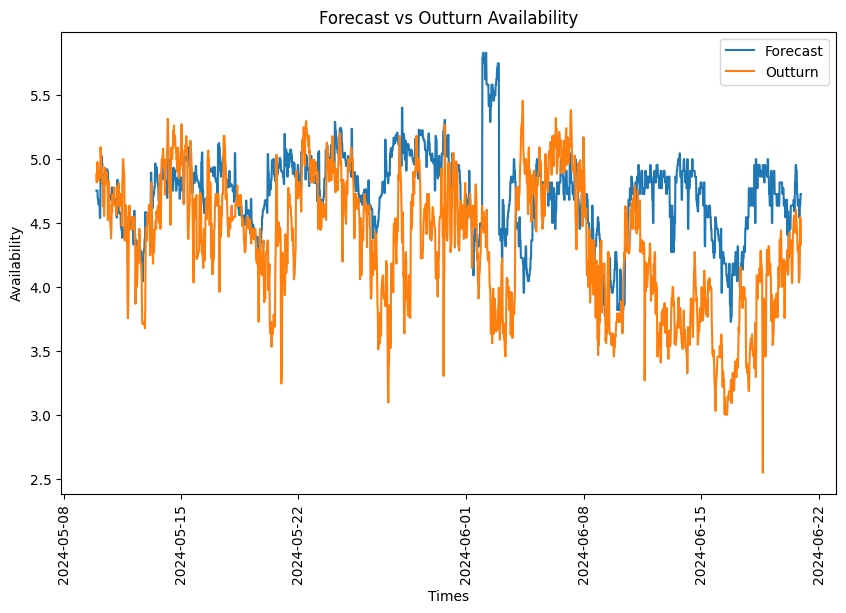

In [43]:
Forecast = ResponseDataToDataFrame(ForecastResponseData, 'ForecastAvailability', ParticipantName)
Outturn = ResponseDataToDataFrame(OutturnResponseData, 'AvgOutturnAvail', ParticipantName)

#changing string to date and time
Forecast['Times'] = pd.to_datetime(Forecast['Times'])
Outturn['Times'] = pd.to_datetime(Outturn['Times'])

#changing forecast fromt UTC to Irish Time
Forecast['Times'] = Forecast['Times'] + pd.DateOffset(hours=1)

#formatted dates for the graph
full_time_range = pd.date_range(start=min(Forecast['Times'].min(), Outturn['Times'].min()), 
                                end=max(Forecast['Times'].max(), Outturn['Times'].max()), 
                                freq='30T')


#Averaging out the data points for any given time 
Forecast = Forecast.groupby('Times').mean().reindex(full_time_range).reset_index()
Outturn = Outturn.groupby('Times').mean().reindex(full_time_range).reset_index()


#formating the graph
Forecast.columns = ['Times', 'Availability']
Outturn.columns = ['Times', 'Availability']

plt.figure(figsize=(10, 6))
plt.plot(Forecast['Times'], Forecast['Availability'], label='Forecast')
plt.plot(Outturn['Times'], Outturn['Availability'], label='Outturn')
plt.xticks(rotation=90)

plt.legend()
plt.xlabel('Times')
plt.ylabel('Availability')
plt.title('Forecast vs Outturn Availability')
plt.show()

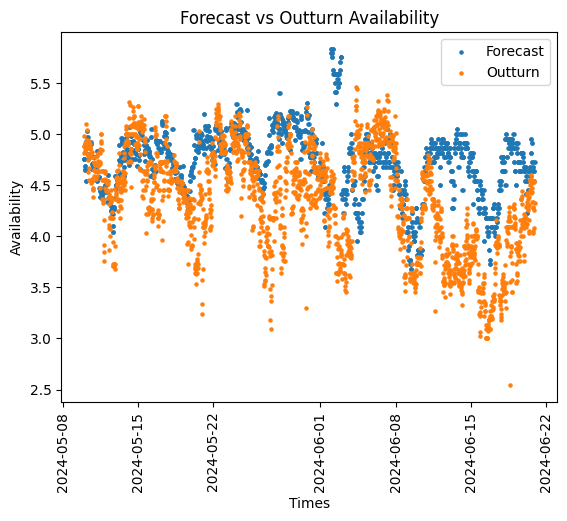

In [46]:

plt.scatter(Forecast['Times'], Forecast['Availability'], label='Forecast',s=5)
plt.scatter(Outturn['Times'], Outturn['Availability'], label='Outturn', s=5)
plt.xticks(rotation=90)

plt.legend()
plt.xlabel('Times')
plt.ylabel('Availability')
plt.title('Forecast vs Outturn Availability')
plt.show()


[np.float64(8762.215272727273), np.float64(9529.850303030304)]


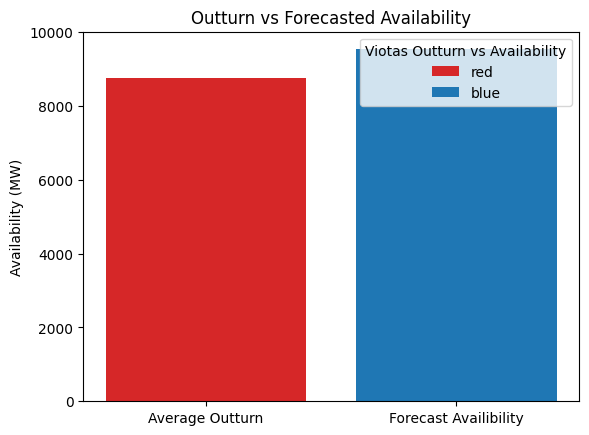

In [69]:
fig, ax = plt.subplots()

labels = ['Average Outturn', 'Forecast Availibility']

counts = [Outturn['Availability'].sum(),Forecast['Availability'].sum()]
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']
print(counts)
ax.bar(labels, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Availability (MW)')
ax.set_title('Outturn vs Forecasted Availability')
ax.legend(title='Viotas Outturn vs Availability')


plt.show()